Mounted at /content/drive
✅ Dataset Loaded | Total Samples: 60353
                                         clause_text    clause_type  \
0  Bank Accounts. The Borrower shall not (and sha...  bank-accounts   
1  Bank Accounts. The Borrower will, and will cau...  bank-accounts   
2  Bank Accounts. All funds of the Company will b...  bank-accounts   
3  Bank Accounts. The Manager may establish and m...  bank-accounts   
4  Bank Accounts. The Board of Managers may from ...  bank-accounts   

           label  
0  bank-accounts  
1  bank-accounts  
2  bank-accounts  
3  bank-accounts  
4  bank-accounts  


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



🚀 Training BiLSTM Model...
Epoch 1/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.0686 - loss: 5.3355 - val_accuracy: 0.5359 - val_loss: 2.4999
Epoch 2/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5477 - loss: 2.3447 - val_accuracy: 0.6593 - val_loss: 1.8452
Epoch 3/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6525 - loss: 1.7588 - val_accuracy: 0.6799 - val_loss: 1.6912
Epoch 4/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6915 - loss: 1.4693 - val_accuracy: 0.6943 - val_loss: 1.6216
Epoch 5/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7131 - loss: 1.3096 - val_accuracy: 0.7043 - val_loss: 1.5032
Epoch 6/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7394 - loss: 1.1124 - val_accuracy: 0.7119 - val_loss: 1.5103
Epoch 7/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7637 - loss: 0.9738 - val_accuracy: 0.7199 - val_loss: 1.4985
Epoch 8/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7

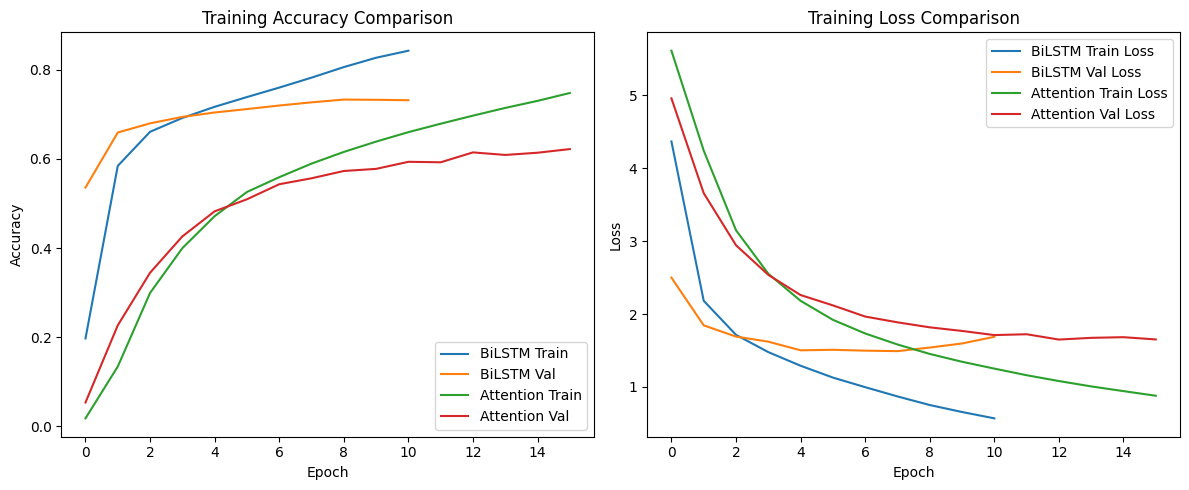

378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

🔍 BiLSTM – Example Predictions:

❌ Incorrect
Clause: Collateral. The Notes and the Note Guarantees are secured by the Note Liens on the Collateral, subject to Permitted Liens and the exclusion of Excluded Property, on the terms and conditions set forth in the Indenture, the Intercreditor Agreement (if ...
True Label: 78 | Predicted: 68
----------------------------------------------------------------------
❌ Incorrect
Clause: Cancellation. This Policy shall not be cancelled by the Company except upon prior written notice thereto to the Insured, and no notice of cancellation shall be effective unless it is based on the occurrence, after the Effective Date of this Policy, o...
True Label: 115 | Predicted: 114
----------------------------------------------------------------------
✅ Correct
Clause: Collateral. No Holder will ask, demand, accept, or receive any collateral security from any Loan Party for the payment of Intercompany Indebtedness, and 

In [1]:
# =====================================
# 📦 SETUP
# =====================================
!pip install tensorflow scikit-learn pandas numpy matplotlib tqdm --quiet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# =====================================
# 🔗 MOUNT DRIVE
# =====================================
from google.colab import drive
drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/datasetdeepassignment2"

# =====================================
# ⚙️ LOAD DATA (Memory Safe)
# =====================================
def load_data(path, sample_frac=0.4):
    """Load CSVs partially to avoid RAM overflow."""
    dataframes = []
    for file in os.listdir(path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, file))
            df = df.sample(frac=sample_frac, random_state=42)
            df['label'] = file.replace('.csv', '')
            dataframes.append(df)
    data = pd.concat(dataframes, ignore_index=True)
    return data

data = load_data(DATASET_DIR, sample_frac=0.4)
print("✅ Dataset Loaded | Total Samples:", len(data))
print(data.head())

# =====================================
# 🧹 PREPROCESSING
# =====================================
clauses = data['clause_text'].astype(str).values
labels = data['label'].astype('category').cat.codes.values  # Encode labels

MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(clauses)
sequences = tokenizer.texts_to_sequences(clauses)
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# =====================================
# 🧠 MODEL 1: BiLSTM
# =====================================
def build_bilstm(vocab_size, embed_dim=128):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

bilstm_model = build_bilstm(MAX_WORDS)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🚀 Training BiLSTM Model...")
bilstm_history = bilstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# =====================================
# 🧠 MODEL 2: ATTENTION ENCODER
# =====================================
def build_attention_encoder(vocab_size, embed_dim=128):
    inputs = Input(shape=(MAX_LEN,))
    x = Embedding(vocab_size, embed_dim)(inputs)
    attn = Attention()([x, x])
    x = GlobalAveragePooling1D()(attn)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(len(np.unique(y_train)), activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

attn_model = build_attention_encoder(MAX_WORDS)

print("\n🚀 Training Attention Encoder Model...")
attn_history = attn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# =====================================
# 📈 EVALUATION FUNCTION
# =====================================
def evaluate_model(model, X_test, y_test, name):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(pd.get_dummies(y_test), y_pred_probs, multi_class='ovr')
    except:
        auc = 0.0
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📊 ===== {name} Model Results =====")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-Score     : {f1:.4f}")
    print(f"ROC-AUC      : {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc, 'cm': cm}

# =====================================
# 🧾 EVALUATE BOTH MODELS
# =====================================
bilstm_metrics = evaluate_model(bilstm_model, X_test, y_test, "BiLSTM")
attn_metrics = evaluate_model(attn_model, X_test, y_test, "Attention Encoder")

# =====================================
# 📊 TRAINING GRAPHS (Accuracy + Loss)
# =====================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history['accuracy'], label='BiLSTM Train')
plt.plot(bilstm_history.history['val_accuracy'], label='BiLSTM Val')
plt.plot(attn_history.history['accuracy'], label='Attention Train')
plt.plot(attn_history.history['val_accuracy'], label='Attention Val')
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bilstm_history.history['loss'], label='BiLSTM Train Loss')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM Val Loss')
plt.plot(attn_history.history['loss'], label='Attention Train Loss')
plt.plot(attn_history.history['val_loss'], label='Attention Val Loss')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# =====================================
# 🧩 QUALITATIVE RESULTS (Correct/Incorrect Predictions)
# =====================================
def show_examples(model, name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"\n🔍 {name} – Example Predictions:\n")
    for i in range(5):
        idx = np.random.randint(0, len(X_test))
        correct = "✅ Correct" if y_pred[idx] == y_test[idx] else "❌ Incorrect"
        print(f"{correct}")
        print(f"Clause: {clauses[idx][:250]}...")
        print(f"True Label: {y_test[idx]} | Predicted: {y_pred[idx]}")
        print("-"*70)

show_examples(bilstm_model, "BiLSTM")
show_examples(attn_model, "Attention Encoder")
